In [1]:
import math
import time
import sys
import numpy as np
import random

import matplotlib
from matplotlib import pyplot as plt

import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
#device = torch.device('mps')
print("INFO: current device: {}".format(device))

import nflows
from nflows import flows
from nflows import transforms
from nflows import distributions

print('Modules loaded :)')

!nvidia-smi

/home/sr39/.conda/envs/torch-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INFO: current device: cuda:0
Modules loaded :)
Sun Feb 18 12:26:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe          On  | 00000000:CA:00.0 Off |                   On |
| N/A   39C    P0              66W / 300W |   1898MiB / 81920MiB |     N/A      Default |
|                                         |                      |              Enabled |
+--------------------

In [2]:
# Set up matplotlib settings
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl


plt.rcParams.update(plt.rcParamsDefault)  # Reset the default matplotlib settings

plt.rcParams['figure.figsize'] = (5, 4)  # Set the figure size (width, height) in inches

plt.rcParams['font.size'] = 12  # Set the font size for labels and titles
plt.rcParams['figure.dpi'] = 150  # Set the DPI (dots per inch) for high-resolution output
plt.rcParams['font.family'] = 'serif'  # Set the font family

plt.rcParams['axes.linewidth'] = 1.5  # Set the linewidth of the axes
plt.rcParams['axes.edgecolor'] = 'black'  # Set the color of the axes' edges
plt.rcParams['axes.spines.top'] = True  # Hide the top spine of the axes
plt.rcParams['axes.spines.right'] = True  # Hide the right spine of the axes

plt.rcParams['xtick.direction'] = 'in'  # Set the direction of x-axis ticks to inward
plt.rcParams['xtick.major.size'] = 4  # Set the size of major x-axis ticks
plt.rcParams['xtick.major.width'] = 1.2  # Set the width of major x-axis ticks
plt.rcParams['xtick.minor.size'] = 2  # Set the size of minor x-axis ticks
plt.rcParams['xtick.minor.width'] = 1.0  # Set the width of minor x-axis ticks

plt.rcParams['ytick.direction'] = 'in'  # Set the direction of y-axis ticks to inward
plt.rcParams['ytick.right'] = True  # Show the y-ticks on the right axis
plt.rcParams['ytick.major.size'] = 4  # Set the size of major y-axis ticks
plt.rcParams['ytick.major.width'] = 1.2  # Set the width of major y-axis ticks
plt.rcParams['ytick.minor.size'] = 2  # Set the size of minor y-axis ticks
plt.rcParams['ytick.minor.width'] = 1.0  # Set the width of minor y-axis ticks

plt.rcParams['lines.linewidth'] = 1.5  # Set the linewidth of the plotted lines
plt.rcParams['legend.frameon'] = False  # Hide the frame of the legend
plt.rcParams['legend.fontsize'] = 10  # Set the font size of the legend

# ... Additional settings as needed ...

# FOR LATEX FONT, CMU SERIF
#mpl.rcParams['font.family'] = 'serif'
#mpl.rcParams['font.serif'] = 'CMU Serif'
#mpl.rcParams['font.sans-serif'] = 'CMU Sans Serif, DejaVu Sans, Bitstream Vera Sans, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif'
#mpl.rcParams['text.usetex'] = True


In [3]:
## Loading in the plummer sphere data
data = np.load('plummer_dumber.npy').astype(np.float32)
print(f'data shape: {data.shape}')

data shape: (1200000, 6)


In [4]:
## function to generate plummer sphere data
## Generate my own data
def mkplummer_vectorised(n, seed=-1):
    if seed == -1:
        np.random.seed()
    else:
        np.random.seed(seed)

    bodies = np.zeros((n, 7))  # Each row: mass, x, y, z, vx, vy, vz
    bodies[:, 0] = 1.0 / n

    # Generate positions
    radius = 1.0 / np.sqrt(np.random.rand(n) ** (-2.0 / 3.0) - 1.0)
    theta = np.arccos(np.random.uniform(-1, 1, n))
    phi = np.random.uniform(0, 2 * np.pi, n)
    bodies[:, 1] = radius * np.sin(theta) * np.cos(phi)
    bodies[:, 2] = radius * np.sin(theta) * np.sin(phi)
    bodies[:, 3] = radius * np.cos(theta)

    # Generate velocities
    x = np.random.rand(n)
    y = np.random.rand(n) * 0.1
    mask = y > x * x * (1.0 - x * x)**3.5
    while np.any(mask):
        x[mask] = np.random.rand(np.sum(mask))
        y[mask] = np.random.rand(np.sum(mask)) * 0.1
        mask = y > x * x * (1.0 - x * x)**3.5

    velocity = x * np.sqrt(2.0) * (1.0 + radius * radius) ** (-0.25)
    theta = np.arccos(np.random.uniform(-1, 1, n))
    phi = np.random.uniform(0, 2 * np.pi, n)
    bodies[:, 4] = velocity * np.sin(theta) * np.cos(phi)
    bodies[:, 5] = velocity * np.sin(theta) * np.sin(phi)
    bodies[:, 6] = velocity * np.cos(theta)

    return bodies

In [5]:
## Some data preprocessing
def remove_rows_exceeding_threshold(array, threshold):
    mask = np.any(array > threshold, axis=1)
    filtered_array = array[~mask]
    return filtered_array

def remove_rows_under_threshold(array, threshold):
    mask = np.any(array < threshold, axis=1)
    filtered_array = array[~mask]
    return filtered_array

threshold = 30

In [6]:
## preprocessing the original data: COMMENT OUT IF YOU WANT THE GENERATE THE DATA YOURSELF
data = remove_rows_exceeding_threshold(data, threshold)
data = remove_rows_under_threshold(data, -threshold)
print(data.shape,flush=True)
scale = np.sqrt((data**2).mean(axis=0))  # mean=0 is assumed
print("scale: {scale}")
arr_scale = np.array(scale)
#np.save(preprocessor_values[i], arr_scale)

#preprocessing functions
def preprocess(arr_input):
    return arr_input / scale
def preprocess_inv(arr_input):
    return arr_input * scale

print('\npreprocessing the data...')
arr_pos_prep = preprocess(data)
print('\npreprocessing done')

(1198579, 6)
scale: {scale}

preprocessing the data...

preprocessing done


In [5]:
## Define the initial MAF and load it in every time before beginning training

#define MAF
# hyper-parameters
INPUT_DIM       = 6
NUM_MAFS        = 6
HIDDEN_FEATURES = 32
NUM_BLOCKS      = 2
PERMUTATION     = [5,0,1,2,3,4]   # must be a permutation of INPUT_DIM integers.
#PERMUTATION     = [5,0,1,2,3,4]   # must be a permutation of INPUT_DIM integers.

# Set random seeds for reproducibility
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

## flow definitions
base_dist = nflows.distributions.normal.StandardNormal(shape=[INPUT_DIM])

list_transforms = []
for k in range(NUM_MAFS):
    if k != 0:
        list_transforms.append(
            nflows.transforms.permutations.Permutation(torch.tensor(PERMUTATION))
        )
    list_transforms.append(
        nflows.transforms.autoregressive.MaskedAffineAutoregressiveTransform(
            features=INPUT_DIM,
            hidden_features=HIDDEN_FEATURES,
            num_blocks=NUM_BLOCKS,
            activation=torch.nn.functional.gelu
        )
    )

transform = nflows.transforms.base.CompositeTransform(list_transforms).to(device)

flow = nflows.flows.base.Flow(transform, base_dist).to(device)

# Save the Initial State
path_temp_wgt = "./wgt_maf_0"
torch.save(flow.state_dict(), path_temp_wgt)


In [10]:
## Datavariance

n_flow = 50

train_sizes = [10000]

#original_stdout = sys.stdout

print('ready to start process...')

dataseeds = np.arange(42,42+n_flow,1)

#preprocessing functions
def preprocess_scale(arr_input,scale):
    return arr_input / scale
def preprocess_inv_scale(arr_input,scale):
    return arr_input * scale

## UNCOMMENT THESE IF YOU WANT TO USE THE ORIGINAL DATA SLICES
arr_pos_prep_valid = mkplummer_vectorised(1000000, seed=0)[:, 1:].astype(np.float32)
arr_pos_prep_valid = remove_rows_exceeding_threshold(arr_pos_prep_valid, threshold)
arr_pos_prep_valid = remove_rows_under_threshold(arr_pos_prep_valid, -threshold)
scale_valid = np.std(arr_pos_prep_valid,axis=0)  # mean=0 is assumed
print(f"scale_valid: {scale_valid}")
arr_scale_valid = np.array(scale_valid)
arr_pos_prep_valid = preprocess_scale(arr_pos_prep_valid,scale_valid)

# Start timing
start_time = time.perf_counter()

for train_size in train_sizes:
    
    losses = np.empty(n_flow, dtype=object)
    
    ## prepare the validation data, comment out if you want to use the original data
    #arr_pos_prep_valid = mkplummer_vectorised(train_size, seed=0)[:, 1:].astype(np.float32)
    #arr_pos_prep_valid = remove_rows_exceeding_threshold(arr_pos_prep_valid, threshold)
    #arr_pos_prep_valid = remove_rows_under_threshold(arr_pos_prep_valid, -threshold)
    #scale_valid = np.std(arr_pos_prep_valid,axis=0)  # mean=0 is assumed
    #print(f"scale_valid: {scale_valid}")
    #arr_scale_valid = np.array(scale_valid)
    
    for i in range (0,n_flow):

        print("\n Working on flow "+str(i),flush=True)

        ##### Prepare train/valid dataset split

        # split dataset -> train:valid = 1:1
        ## COMMENT THIS OUT IF YOU WANT TO USE THE ORIGINAL DATA TO DERIVE THE SCALE
        arr_pos = mkplummer_vectorised(train_size, seed=dataseeds[i])[:, 1:].astype(np.float32)
        arr_pos = remove_rows_exceeding_threshold(arr_pos, threshold)
        arr_pos = remove_rows_under_threshold(arr_pos, -threshold)
        scale = np.std(arr_pos,axis=0)  # mean=0 is assumed
        print(f"scale: {scale}")
        arr_scale = np.array(scale)
                
        arr_pos_prep_train = preprocess_scale(arr_pos,scale)
        #if i == 0: # only do this for the first time; REMOVE THIS IF STATEMENT IF JUST SLICING ORIGINAL DATA
            #arr_pos_prep_valid = preprocess_scale(arr_pos_prep_valid,scale_valid)
        
        ## Uncomment these lines if you want to use the original data, not the generated data
        #arr_pos_prep_train = arr_pos_prep[train_size*i:train_size*(i+1)]
        #arr_pos_prep_valid = arr_pos_prep[-train_size:]
        print("training dataset   | shape: ", arr_pos_prep_train.shape,flush=True)
        print("max  : ",arr_pos_prep_train.max(axis=0),flush=True)
        print("min  : ",arr_pos_prep_train.min(axis=0),flush=True)
        print("mean : ",arr_pos_prep_train.mean(axis=0),flush=True)
        print("std  : ",arr_pos_prep_train.std(axis=0),flush=True)
        print("validation dataset | shape: ", arr_pos_prep_valid.shape,flush=True)
        print("max  : ",arr_pos_prep_valid.max(axis=0),flush=True)
        print("min  : ",arr_pos_prep_valid.min(axis=0),flush=True)
        print("mean : ",arr_pos_prep_valid.mean(axis=0),flush=True)
        print("std  : ",arr_pos_prep_valid.std(axis=0),flush=True)

        #define MAF

        # hyper-parameters
        INPUT_DIM       = 6
        NUM_MAFS        = 6
        HIDDEN_FEATURES = 32
        NUM_BLOCKS      = 2
        PERMUTATION     = [5,0,1,2,3,4]   # must be a permutation of INPUT_DIM integers.
        #PERMUTATION     = [5,0,1,2,3,4]   # must be a permutation of INPUT_DIM integers.

        ## flow definitions
        base_dist = nflows.distributions.normal.StandardNormal(shape=[INPUT_DIM])

        list_transforms = []
        for k in range(NUM_MAFS):
            if k != 0:
                list_transforms.append(
                    nflows.transforms.permutations.Permutation(torch.tensor(PERMUTATION))
                )
            list_transforms.append(
                nflows.transforms.autoregressive.MaskedAffineAutoregressiveTransform(
                    features=INPUT_DIM,
                    hidden_features=HIDDEN_FEATURES,
                    num_blocks=NUM_BLOCKS,
                    activation=torch.nn.functional.gelu
                )
            )

        transform = nflows.transforms.base.CompositeTransform(list_transforms).to(device)

        flow = nflows.flows.base.Flow(transform, base_dist).to(device)

        # loading in the same initial MAF
        path_temp_wgt = "./wgt_maf_0"
        path_log_file = "./wgt_maf_0.log"
        flow.load_state_dict(torch.load(path_temp_wgt, map_location='cpu'))
        flow.to(device)

        num_param = sum(p.numel() for p in flow.parameters())
        if i==0:print("number of params: ", num_param,flush=True)

        #training

        # we will use ADAM with default parameters:
        LEARNING_RATE = 0.001

        # define optimizer: 
        optimizer = torch.optim.Adam(
            flow.parameters(),
            lr=LEARNING_RATE
        )

        # negative log likelihood loss function 
        #   mode: mean or sum
        def calc_loss(tensor_input, mode="mean"):
            arr_nll = -flow.log_prob(tensor_input)
            if mode == "mean":
                return arr_nll.mean()
            elif mode == "sum":
                return arr_nll.sum()
            else:
                assert False

        # training parameters
        ##############################
        num_epoch_max = 1000
        batch_size_train     = 2**10
        batch_size_inference = 2**15

        # parameters for early stopping
        patience_max=60

        # temporary file save path
        path_temp_wgt = "./wgt_maf_"+str(train_size)+"janky_data"#path_temp_wgt = path_temp_wgts[i]
        path_log_file = "./wgt_maf_"+str(train_size)+"janky_data.log"#path_log_file = path_log_files[i]

        #training

        # auxilary function for logging purpose
        def print_log(fp, txt):
            print(txt,flush=True)
            fp.writelines(txt+"\n")
            fp.flush()

        # training parameters
        ##############################
        n_batch_train = arr_pos_prep_train.shape[0] // batch_size_train + 1
        n_batch_train_inf = arr_pos_prep_train.shape[0] // batch_size_inference + 1
        n_batch_valid_inf = arr_pos_prep_valid.shape[0] // batch_size_inference + 1

        # timer...
        time_start = time.time()

        # best loss value
        loss_best = np.inf

        # early stopping: patience
        patience=0  

        # load data to GPU:
        tensor_pos_prep_train = torch.tensor(arr_pos_prep_train, device=device)
        tensor_pos_prep_valid = torch.tensor(arr_pos_prep_valid, device=device)

        # split data into batches for loss evaluation
        list_tensor_pos_prep_train = torch.tensor_split(tensor_pos_prep_train, n_batch_train_inf)
        list_tensor_pos_prep_valid = torch.tensor_split(tensor_pos_prep_valid, n_batch_valid_inf)

        # monitor value
        list_loss_train = []
        list_loss_valid = []

        # training loop!
        ###########################
        # open log file
        with open(path_log_file, 'w') as fp:

            # training loop:
            for epoch in range(num_epoch_max):

                # calculate training loss 
                loss_train = torch.tensor(0., dtype=torch.float32, device=device)
                with torch.inference_mode():
                    for buf_pos_prep in list_tensor_pos_prep_train:
                        loss_train = loss_train + calc_loss(buf_pos_prep, "sum")
                    loss_train = loss_train.detach().cpu().numpy() / tensor_pos_prep_train.shape[0]
                    list_loss_train.append(loss_train)

                # calculate validation loss
                loss_valid = torch.tensor(0., dtype=torch.float32, device=device)
                with torch.inference_mode():
                    for buf_pos_prep in list_tensor_pos_prep_valid:
                        loss_valid = loss_valid + calc_loss(buf_pos_prep, "sum")
                    loss_valid = loss_valid.detach().cpu().numpy() / tensor_pos_prep_valid.shape[0]
                    list_loss_valid.append(loss_valid)

                # is model improved?
                if loss_best > loss_valid: 
                    #print_log(fp, "epoch {:04d}: loss improved {:.4f} -> {:.4f}".format(epoch, loss_best, loss_valid))
                    loss_best = loss_valid
                    torch.save(flow.state_dict(), path_temp_wgt)
                    patience=0
                else:
                    # if model is not improved, check the early stopping criterion
                    if patience < patience_max:
                        patience += 1
                    else:
                        print_log(fp, "maximum patience reached")
                        break

                # shuffle and generate minibatches for training
                batches_tensor_pos_prep_train = torch.tensor_split(
                    tensor_pos_prep_train[
                        torch.randperm(tensor_pos_prep_train.shape[0], device=device)
                    ], 
                    n_batch_train
                )

                # update model!
                for buf_pos_prep in batches_tensor_pos_prep_train:
                    # zero grad
                    optimizer.zero_grad()

                    # evaluate training loss and gradients
                    buf_loss = calc_loss(buf_pos_prep, "mean")
                    buf_loss.backward()

                    # update model    
                    optimizer.step()

                # print timer information....
                if (epoch+1)<5 or (epoch+1) % 50 == 0:
                    time_current = time.time()
                    print_log(fp, "INFO: epoch {:04d} | time_elapsed: {:.3f}s".format(epoch+1, time_current - time_start))
                    print_log(fp, "INFO:            | loss_train: {:.4f} | loss_valid: {:.4f} | loss_best: {:.4f}".format(loss_train, loss_valid, loss_best))


            # training loop finished
            losses[i]=loss_best
            print("validation loss: "+str(loss_best),flush=True)

            flow.load_state_dict(torch.load(path_temp_wgt, map_location='cpu'))
            flow.to(device)
            #plt.plot(plot_flow(flow)[0],plot_flow(flow)[1],c='grey',alpha=0.25)

            print_log(fp, "INFO: training finished")

            '''block_vars = ['transform','base_dist','list_transforms','flow','scale', 'arr_scale', 'arr_pos_prep', 'arr_pos_prep_train', 'arr_pos_prep_valid', 'num_param',
                  'optimizer', 'calc_loss', 'num_epoch_max', 'batch_size_train', 'batch_size_inference',
                  'patience_max', 'path_temp_wgt', 'path_log_file', 'n_batch_train', 'n_batch_train_inf',
                  'n_batch_valid_inf', 'time_start', 'loss_best', 'patience', 'tensor_pos_prep_train',
                  'tensor_pos_prep_valid', 'list_tensor_pos_prep_train', 'list_tensor_pos_prep_valid',
                  'list_loss_train', 'list_loss_valid']

            for var in block_vars:
                if var in locals():
                    del locals()[var]'''

    np.save(str(train_size)+'_datavariance_losses_janky.npy',losses)

# End timing
end_time = time.perf_counter()

# Calculate the duration
duration = end_time - start_time
print(f"\nThe code took {duration} seconds to run.")

ready to start process...
scale_valid: [1.7155879  1.722829   1.7151111  0.31306332 0.3135168  0.31333336]

 Working on flow 0
scale: [1.6431824  1.6491388  1.6778663  0.3132841  0.3163313  0.31448555]
training dataset   | shape:  (9991, 6)
max  :  [13.304003  15.157764  16.484919   3.4216967  3.8015018  3.530729 ]
min  :  [-16.32007   -12.41825   -12.100842   -3.3233178  -3.4086347  -3.521052 ]
mean :  [-0.00855986 -0.00244627  0.01787699  0.01138009  0.00546337  0.00972139]
std  :  [0.99999905 1.000001   0.99999875 1.0000007  1.         0.9999999 ]
validation dataset | shape:  (998781, 6)
max  :  [17.485348  17.328411  17.479908   3.9258473  3.9679961  4.187494 ]
min  :  [-17.47059   -17.364206  -17.442602   -3.9730756  -4.045677   -4.1131916]
mean :  [-0.0012247   0.00111046 -0.00113699  0.00087525  0.00022484  0.00119668]
std  :  [1.0000949 1.0000775 1.0000693 1.0000434 1.0000374 1.0000625]
number of params:  29064
INFO: epoch 0001 | time_elapsed: 0.264s
INFO:            | loss_tra

KeyboardInterrupt: 

In [34]:
print(f'losses: {losses}\nloss standard dev.: {np.std(losses)}\nloss mean: {np.mean(losses)}')

losses: [4.519362890625 4.4746484375 4.82956796875 5.019903125 4.658697265625
 5.382122265625 4.722096875 5.006546875 4.72675546875 4.48756875
 4.554359375 4.74894609375 4.4393984375 4.635091015625 4.950856640625
 4.45588828125 4.57321015625 4.53478984375 4.887949609375 4.548953125
 4.462064453125 4.567212890625 5.199087109375 4.79433125 4.82097421875
 4.4583375 4.75556171875 4.8061921875 4.9799625 4.44868984375
 4.91145703125 4.770525 7.13913125 4.79499296875 4.54755625 4.66330859375
 4.41018203125 4.530784375 4.326796484375 4.916971875 4.571209375
 4.84178359375 5.325519921875 4.55250703125 13.0557578125 4.72765234375
 5.13865625 4.8241625 5.01444296875 4.765720703125]
loss standard dev.: 1.2295324969950836
loss mean: 4.945564890624999


In [39]:
data_losses_1000 = np.load('1000_datavariance_losses.npy',allow_pickle=True)
data_losses_5000 = np.load('5000_datavariance_losses.npy',allow_pickle=True)
data_losses_10000 = np.load('10000_datavariance_losses.npy',allow_pickle=True)
data_losses_50000 = np.load('50000_datavariance_losses.npy',allow_pickle=True)

In [41]:
print(f'data losses 1000: mean = {np.mean(data_losses_1000)}; std dev = {np.std(data_losses_1000)}')
print(f'data losses 5000: mean = {np.mean(data_losses_5000)}; std dev = {np.std(data_losses_5000)}')
print(f'data losses 10000: mean = {np.mean(data_losses_10000)}; std dev = {np.std(data_losses_10000)}')
print(f'data losses 50000: mean = {np.mean(data_losses_50000)}; std dev = {np.std(data_losses_50000)}')

data losses 1000: mean = 4.437338505859375; std dev = 0.050172827147653164
data losses 5000: mean = 4.945564890624999; std dev = 1.2295324969950836


In [8]:
## MAF initialisation variance

# use the same n_flow and train_size as above
losses_init = np.empty(n_flow, dtype=object)
init_seeds = np.arange(42,42+n_flow,1)

#original_stdout = sys.stdout

print('ready to start process...')

# Start timing
start_time = time.perf_counter()

## UNCOMMENT IF YOU WANT TO SLICE THE ORIGINAL DATA: preprocessing, if you want to use the original data
#print(data.shape,flush=True)
#scale = np.sqrt((data**2).mean(axis=0))  # mean=0 is assumed
#print(f"scale: {scale}")
#arr_scale = np.array(scale)
#np.save(preprocessor_values[i], arr_scale)

#def preprocess(arr_input):
#    return arr_input / scale
#def preprocess_inv(arr_input):
#    return arr_input * scale

#print('\npreprocessing the data...')
#arr_pos_prep = preprocess(data)
#print('\npreprocessing done')

#preprocessing functions
def preprocess_scale(arr_input,scale):
    return arr_input / scale
def preprocess_inv_scale(arr_input,scale):
    return arr_input * scale

## COMMENT THIS OUT IF YOU WANT TO USE ORIGINAL DATA SLICES
arr_pos_prep_valid = mkplummer_vectorised(1000000, seed=0)[:, 1:].astype(np.float32)
arr_pos_prep_valid = remove_rows_exceeding_threshold(arr_pos_prep_valid, threshold)
arr_pos_prep_valid = remove_rows_under_threshold(arr_pos_prep_valid, -threshold)
scale_valid = np.std(arr_pos_prep_valid,axis=0)  # mean=0 is assumed
arr_scale_valid = np.array(scale_valid)
print(f"scale_valid: {scale_valid}")
arr_pos_prep_valid = preprocess_scale(arr_pos_prep_valid,scale_valid)

# Create a file and redirect the standard output to it
for train_size in train_sizes:
    
    losses_init = np.empty(n_flow, dtype=object)
    
    #sys.stdout = file

    for i in range (0,n_flow):

        print("\n Working on flow "+str(i),flush=True)

        #Prepare train/valid dataset split

        # split dataset -> train:valid = 1:1
        
        ## COMMENT THIS OUT IF YOU WANT TO USE THE ORIGINAL DATA TO DERIVE THE SCALE
        if i == 0:
            arr_pos = mkplummer_vectorised(train_size, seed=42)[:, 1:].astype(np.float32)
            arr_pos = remove_rows_exceeding_threshold(arr_pos, threshold)
            arr_pos = remove_rows_under_threshold(arr_pos, -threshold)
            scale = np.std(arr_pos,axis=0)  # mean=0 is assumed
            print(f"scale: {scale}")
            arr_scale = np.array(scale)
            #arr_pos_prep_valid = mkplummer_vectorised(train_size, seed=0)[:, 1:].astype(np.float32)
            #arr_pos_prep_valid = remove_rows_exceeding_threshold(arr_pos_prep_valid, threshold)
            #arr_pos_prep_valid = remove_rows_under_threshold(arr_pos_prep_valid, -threshold)
            #scale_valid = np.std(arr_pos_prep_valid,axis=0)  # mean=0 is assumed
            #arr_scale_valid = np.array(scale_valid)
            #print(f"scale_valid: {scale_valid}")

            #arr_pos_prep_valid = preprocess_scale(arr_pos_prep_valid,scale_valid)
            arr_pos_prep_train = preprocess_scale(arr_pos,scale)
        
        ## UN-COMMENT THIS IF YOU WANT TO SLICE ORIGINAL DATA
        #arr_pos_prep_train = arr_pos_prep[0:train_size] # initialise the training data to be the first 1000 samples, but could realistically pick any 1000 samples
        #arr_pos_prep_valid = arr_pos_prep[-train_size:]
        print("training dataset   | shape: ", arr_pos_prep_train.shape,flush=True)
        print("max  : ",arr_pos_prep_train.max(axis=0),flush=True)
        print("min  : ",arr_pos_prep_train.min(axis=0),flush=True)
        print("mean : ",arr_pos_prep_train.mean(axis=0),flush=True)
        print("std  : ",arr_pos_prep_train.std(axis=0),flush=True)
        print("validation dataset | shape: ", arr_pos_prep_valid.shape,flush=True)
        print("max  : ",arr_pos_prep_valid.max(axis=0),flush=True)
        print("min  : ",arr_pos_prep_valid.min(axis=0),flush=True)
        print("mean : ",arr_pos_prep_valid.mean(axis=0),flush=True)
        print("std  : ",arr_pos_prep_valid.std(axis=0),flush=True)

        #define MAF

        # hyper-parameters
        INPUT_DIM       = 6
        NUM_MAFS        = 6
        HIDDEN_FEATURES = 32
        NUM_BLOCKS      = 2
        PERMUTATION     = [5,0,1,2,3,4]   # must be a permutation of INPUT_DIM integers.
        #PERMUTATION     = [5,0,1,2,3,4]   # must be a permutation of INPUT_DIM integers.

        ## flow definitions
        base_dist = nflows.distributions.normal.StandardNormal(shape=[INPUT_DIM])

        list_transforms = []
        for k in range(NUM_MAFS):
            if k != 0:
                list_transforms.append(
                    nflows.transforms.permutations.Permutation(torch.tensor(PERMUTATION))
                )
            list_transforms.append(
                nflows.transforms.autoregressive.MaskedAffineAutoregressiveTransform(
                    features=INPUT_DIM,
                    hidden_features=HIDDEN_FEATURES,
                    num_blocks=NUM_BLOCKS,
                    activation=torch.nn.functional.gelu
                )
            )

        # initialising the random MAF with the corresponding random seed
        torch.manual_seed(init_seeds[i])

        transform = nflows.transforms.base.CompositeTransform(list_transforms).to(device)

        flow = nflows.flows.base.Flow(transform, base_dist).to(device)

        num_param = sum(p.numel() for p in flow.parameters())
        if i==0:print("number of params: ", num_param,flush=True)

        #training

        # we will use ADAM with default parameters:
        LEARNING_RATE = 0.001

        # define optimizer: 
        optimizer = torch.optim.Adam(
            flow.parameters(),
            lr=LEARNING_RATE
        )

        # negative log likelihood loss function 
        #   mode: mean or sum
        def calc_loss(tensor_input, mode="mean"):
            arr_nll = -flow.log_prob(tensor_input)
            if mode == "mean":
                return arr_nll.mean()
            elif mode == "sum":
                return arr_nll.sum()
            else:
                assert False

        # training parameters
        ##############################
        num_epoch_max = 1000
        batch_size_train     = 2**10
        batch_size_inference = 2**15

        # parameters for early stopping
        patience_max=20

        # temporary file save path
        path_temp_wgt = "./wgt_maf_"+str(train_size)+"_init"#path_temp_wgt = path_temp_wgts[i]
        path_log_file = "./wgt_maf_"+str(train_size)+"_init.log"#path_log_file = path_log_files[i]

        #training

        # auxilary function for logging purpose
        def print_log(fp, txt):
            print(txt,flush=True)
            fp.writelines(txt+"\n")
            fp.flush()

        # training parameters
        ##############################
        n_batch_train = arr_pos_prep_train.shape[0] // batch_size_train + 1
        n_batch_train_inf = arr_pos_prep_train.shape[0] // batch_size_inference + 1
        n_batch_valid_inf = arr_pos_prep_valid.shape[0] // batch_size_inference + 1

        # timer...
        time_start = time.time()

        # best loss value
        loss_best = np.inf

        # early stopping: patience
        patience=0  

        # load data to GPU:
        tensor_pos_prep_train = torch.tensor(arr_pos_prep_train, device=device)
        tensor_pos_prep_valid = torch.tensor(arr_pos_prep_valid, device=device)

        # split data into batches for loss evaluation
        list_tensor_pos_prep_train = torch.tensor_split(tensor_pos_prep_train, n_batch_train_inf)
        list_tensor_pos_prep_valid = torch.tensor_split(tensor_pos_prep_valid, n_batch_valid_inf)

        # monitor value
        list_loss_train = []
        list_loss_valid = []

        # training loop!
        ###########################
        # open log file
        with open(path_log_file, 'w') as fp:

            # training loop:
            for epoch in range(num_epoch_max):

                # calculate training loss 
                loss_train = torch.tensor(0., dtype=torch.float32, device=device)
                with torch.inference_mode():
                    for buf_pos_prep in list_tensor_pos_prep_train:
                        loss_train = loss_train + calc_loss(buf_pos_prep, "sum")
                    loss_train = loss_train.detach().cpu().numpy() / tensor_pos_prep_train.shape[0]
                    list_loss_train.append(loss_train)

                # calculate validation loss
                loss_valid = torch.tensor(0., dtype=torch.float32, device=device)
                with torch.inference_mode():
                    for buf_pos_prep in list_tensor_pos_prep_valid:
                        loss_valid = loss_valid + calc_loss(buf_pos_prep, "sum")
                    loss_valid = loss_valid.detach().cpu().numpy() / tensor_pos_prep_valid.shape[0]
                    list_loss_valid.append(loss_valid)

                # is model improved?
                if loss_best > loss_valid: 
                    #print_log(fp, "epoch {:04d}: loss improved {:.4f} -> {:.4f}".format(epoch, loss_best, loss_valid))
                    loss_best = loss_valid
                    torch.save(flow.state_dict(), path_temp_wgt)
                    patience=0
                else:
                    # if model is not improved, check the early stopping criterion
                    if patience < patience_max:
                        patience += 1
                    else:
                        print_log(fp, "maximum patience reached")
                        break

                # shuffle and generate minibatches for training
                batches_tensor_pos_prep_train = torch.tensor_split(
                    tensor_pos_prep_train[
                        torch.randperm(tensor_pos_prep_train.shape[0], device=device)
                    ], 
                    n_batch_train
                )

                # update model!
                for buf_pos_prep in batches_tensor_pos_prep_train:
                    # zero grad
                    optimizer.zero_grad()

                    # evaluate training loss and gradients
                    buf_loss = calc_loss(buf_pos_prep, "mean")
                    buf_loss.backward()

                    # update model    
                    optimizer.step()

                # print timer information....
                if (epoch+1)<5 or (epoch+1) % 50 == 0:
                    time_current = time.time()
                    print_log(fp, "INFO: epoch {:04d} | time_elapsed: {:.3f}s".format(epoch+1, time_current - time_start))
                    print_log(fp, "INFO:            | loss_train: {:.4f} | loss_valid: {:.4f} | loss_best: {:.4f}".format(loss_train, loss_valid, loss_best))


            # training loop finished
            losses_init[i]=loss_best
            print("validation loss: "+str(loss_best),flush=True)

            flow.load_state_dict(torch.load(path_temp_wgt, map_location='cpu'))
            flow.to(device)
            #plt.plot(plot_flow(flow)[0],plot_flow(flow)[1],c='grey',alpha=0.25)

            print_log(fp, "INFO: training finished")

            '''block_vars = ['transform','base_dist','list_transforms','flow','scale', 'arr_scale', 'arr_pos_prep', 'arr_pos_prep_train', 'arr_pos_prep_valid', 'num_param',
                  'optimizer', 'calc_loss', 'num_epoch_max', 'batch_size_train', 'batch_size_inference',
                  'patience_max', 'path_temp_wgt', 'path_log_file', 'n_batch_train', 'n_batch_train_inf',
                  'n_batch_valid_inf', 'time_start', 'loss_best', 'patience', 'tensor_pos_prep_train',
                  'tensor_pos_prep_valid', 'list_tensor_pos_prep_train', 'list_tensor_pos_prep_valid',
                  'list_loss_train', 'list_loss_valid']

            for var in block_vars:
                if var in locals():
                    del locals()[var]'''

    '''plt.plot(plot_true()[0],plot_true()[1],c='black',label='true')
    plt.xlabel('x')
    plt.ylabel('f')
    plt.title(str(train_size)+' samples (data variance)')
    plt.text(-2,0.023,'mean KL: '+str(round(np.mean(losses),5))+'\n std KL: '+str(round(np.std(losses),5)))
    plt.legend()
    #plt.ioff()
    plt.show()'''
    np.save(str(train_size)+'_initvariance_losses.npy',losses_init)
    
# End timing
end_time = time.perf_counter()

# Calculate the duration
duration = end_time - start_time
print(f"\nThe code took {duration} seconds to run.")


ready to start process...
scale_valid: [1.7155879  1.722829   1.7151111  0.31306332 0.3135168  0.31333336]

 Working on flow 0
scale: [1.7206838  1.7042793  1.7023597  0.31257927 0.3133685  0.31314242]
training dataset   | shape:  (99891, 6)
max  :  [16.802898  17.441936  17.31494    3.7855005  3.88092    3.8409755]
min  :  [-17.336035 -17.463118 -17.551636  -3.976949  -4.179058  -3.859137]
mean :  [-0.00062882  0.00315388  0.00555754 -0.00048259  0.00530799  0.00502945]
std  :  [0.9999985  1.0000036  0.9999982  1.0000033  0.99999964 1.0000064 ]
validation dataset | shape:  (998781, 6)
max  :  [17.485348  17.328411  17.479908   3.9258473  3.9679961  4.187494 ]
min  :  [-17.47059   -17.364206  -17.442602   -3.9730756  -4.045677   -4.1131916]
mean :  [-0.0012247   0.00111046 -0.00113699  0.00087525  0.00022484  0.00119668]
std  :  [1.0000949 1.0000775 1.0000693 1.0000434 1.0000374 1.0000625]
number of params:  29064
INFO: epoch 0001 | time_elapsed: 1.073s
INFO:            | loss_train: 1

KeyboardInterrupt: 

In [44]:
print(f'losses_init: {losses_init}\nstd dev of losses_init: {np.std(losses_init)}\nmean of losses_init: {np.mean(losses_init)}')

losses_init: [5.498472265625 4.824246484375 4.606948046875 4.82598046875 4.530485546875
 4.653938671875 5.18975625 5.57773359375 4.701001171875 4.547225390625
 19.670684375 4.724084765625 4.370050390625 5.0492765625 4.9553265625
 4.4138859375 4.814296875 16.694165625 4.507201953125 4.72752421875
 4.61984296875 9.0741109375 5.01338359375 5.86544765625 4.63628203125
 4.9972875 5.54924921875 6.186455859375 14.524290625 8.3114328125
 4.865748828125 5.07002890625 6.5662109375 4.76133046875 4.81390625
 4.572400390625 5.0045546875 6.612396875 4.34202421875 4.66163515625
 5.181102734375 5.8630671875 5.09770390625 16.387575 13.2775046875
 5.830380078125 5.336408984375 5.409188671875 4.53171875 14.9869]
std dev of losses_init: 3.6590852210568214
mean of losses_init: 6.496637101562499


## Loading in losses and loss variances

In [20]:
train_sizes = [10000,15000,25000,35000,50000,75000,100000,150000,200000,250000]
#datalosses = np.zeros((len(train_sizes),50))
#initlosses = np.zeros((len(train_sizes),50))
datalosses = []
initlosses = []
for i, size in enumerate(train_sizes):
    #datalosses[i,:] = np.load(f'{size}_datavariance_losses.npy',allow_pickle=True)
    #initlosses[i,:] = np.load(f'{size}_initvariance_losses.npy',allow_pickle=True)
    datalosses.append(np.load(f'{size}_datavariance_losses.npy',allow_pickle=True))
    initlosses.append(np.load(f'{size}_initvariance_losses.npy',allow_pickle=True))

# some fudging here. comment out if it's not necessary
fudge_array = np.append(datalosses[-1],np.ones(2)*100.)
datalosses[-1] = fudge_array

datalosses = np.asarray(datalosses)
initlosses = np.asarray(initlosses)

In [21]:
datalosses[-1].shape

(500,)

In [22]:
#print(initlosses[3].shape)
[datalosses.shape, initlosses.shape]

[(10, 500), (10, 500)]

In [23]:
# compute the mean losses ignoring losses above 5. 
datalosses_mean = np.zeros(len(train_sizes))
initlosses_mean = np.zeros(len(train_sizes))
datalosses_std = np.zeros(len(train_sizes))
initlosses_std = np.zeros(len(train_sizes))
loss_threshold = 8.0
for i in range(len(train_sizes)):
    datalosses_mean[i] = np.mean(datalosses[i,:][datalosses[i,:]<loss_threshold])
    initlosses_mean[i] = np.mean(initlosses[i,:][initlosses[i,:]<loss_threshold])
    datalosses_std[i] = np.std(datalosses[i,:][datalosses[i,:]<loss_threshold])
    initlosses_std[i] = np.std(initlosses[i,:][initlosses[i,:]<loss_threshold])

datalosses_max = np.max(datalosses,axis=1)
initlosses_max = np.max(initlosses,axis=1)

(7.057, 7.101)

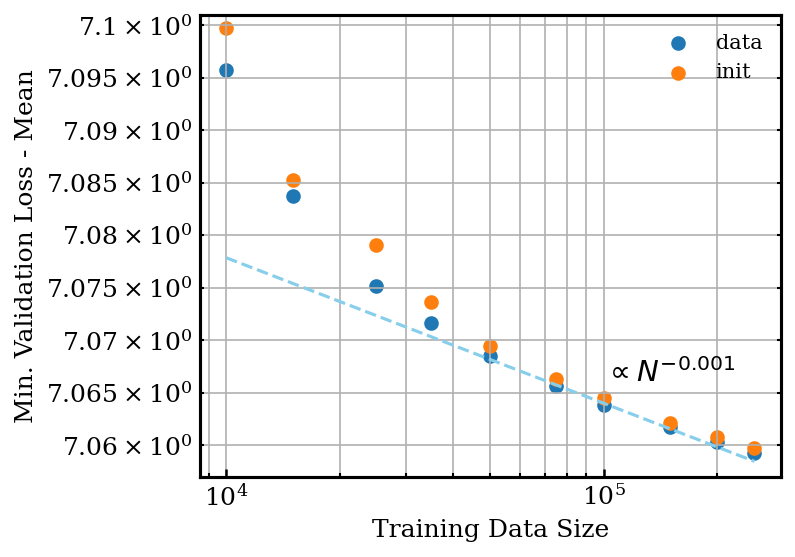

In [69]:
plt.figure(figsize=(5,4))

plt.scatter(train_sizes,datalosses_mean,label='data',linestyle='solid')
plt.scatter(train_sizes,initlosses_mean,label='init',linestyle='solid')

sizes_array = np.logspace(4,5.4,100)
plt.plot(sizes_array,7.064 * (sizes_array/(1.0e5))**(-0.00085),color='skyblue',linestyle='dashed')
#plt.plot(sizes_array,7.0e2 * (sizes_array)**(-0.53),color='orange',linestyle='dashed')

plt.text(1.0e5,7.066,r'$\propto N^{-0.001}$',fontsize=14,color='k')

plt.xlabel('Training Data Size')
plt.ylabel('Min. Validation Loss - Mean')
plt.legend(loc='best')
plt.yscale('log')
plt.xscale('log')
plt.grid(which='both')
plt.ylim([7.057,7.101])

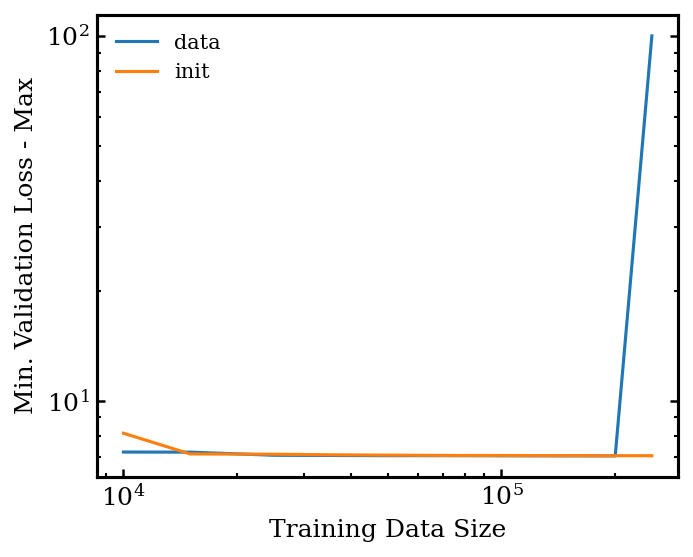

In [25]:
plt.figure(figsize=(5,4))

plt.plot(train_sizes,datalosses_max,label='data',linestyle='solid')
plt.plot(train_sizes,initlosses_max,label='init',linestyle='solid')

plt.xlabel('Training Data Size')
plt.ylabel('Min. Validation Loss - Max')
plt.legend(loc='best')
plt.yscale('log')
plt.xscale('log')

(0.0003, 0.04)

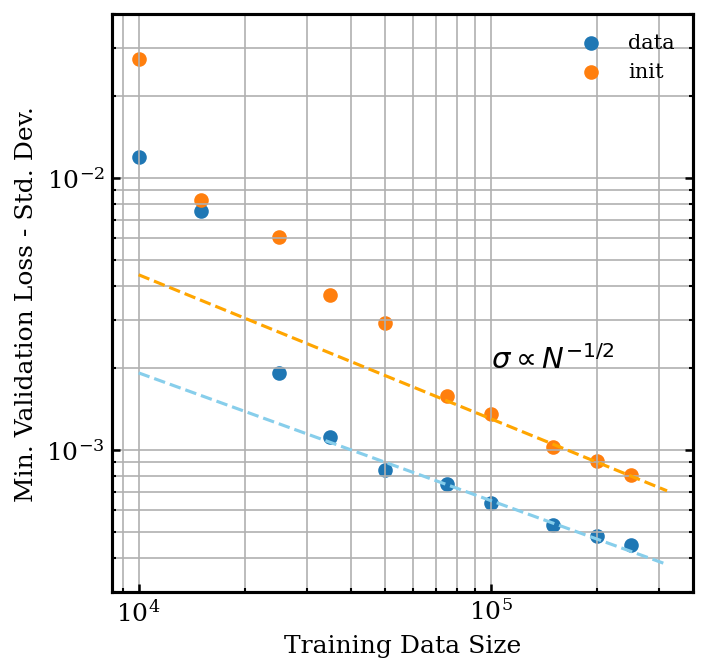

In [65]:
plt.figure(figsize=(5,5))

plt.scatter(train_sizes,datalosses_std,label='data',linestyle='solid')
plt.scatter(train_sizes,initlosses_std,label='init',linestyle='solid')

sizes_array = np.logspace(4,5.5,100)
plt.plot(sizes_array,6.5e-4  * (sizes_array/(1.0e5))**(-0.47),color='skyblue',linestyle='dashed')
#plt.plot(sizes_array,4.0e6 * (sizes_array)**(-2.1),color='skyblue',linestyle='dashed')

plt.plot(sizes_array,1.3e-3 * (sizes_array/(1.0e5))**(-0.53),color='orange',linestyle='dashed')
#plt.plot(sizes_array,2.5e4 * (sizes_array)**(-1.5),color='orange',linestyle='dashed')

#plt.axvline(12500)

plt.text(1.0e5,2e-3,r'$\sigma\propto N^{-1/2}$',fontsize=14,color='k')

plt.xlabel('Training Data Size')
plt.ylabel('Min. Validation Loss - Std. Dev.')
plt.legend(loc='best')
plt.grid(which='both')
plt.yscale('log')
plt.xscale('log')
plt.ylim([3.0e-4,4.0e-2])

## Validating the trained NF

In [127]:
#### Generating a dataset with one of the trained MAFs (to be compared to the actual distribution)

## Initialising the model

# hyper-parameters
INPUT_DIM       = 6
NUM_MAFS        = 6
HIDDEN_FEATURES = 32
NUM_BLOCKS      = 2
PERMUTATION     = [5,0,1,2,3,4]   # must be a permutation of INPUT_DIM integers.
#PERMUTATION     = [5,0,1,2,3,4]   # must be a permutation of INPUT_DIM integers.

# Set random seeds for reproducibility
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

## flow definitions
base_dist = nflows.distributions.normal.StandardNormal(shape=[INPUT_DIM])

list_transforms = []
for k in range(NUM_MAFS):
    if k != 0:
        list_transforms.append(
            nflows.transforms.permutations.Permutation(torch.tensor(PERMUTATION))
        )
    list_transforms.append(
        nflows.transforms.autoregressive.MaskedAffineAutoregressiveTransform(
            features=INPUT_DIM,
            hidden_features=HIDDEN_FEATURES,
            num_blocks=NUM_BLOCKS,
            activation=torch.nn.functional.gelu
        )
    )

transform = nflows.transforms.base.CompositeTransform(list_transforms).to(device)

flow = nflows.flows.base.Flow(transform, base_dist).to(device)

n_train = 250000

# reload a given model
flow.load_state_dict(torch.load(f'./wgt_maf_{int(n_train)}_data', map_location='cpu'))
flow.to(device);

In [128]:
## original dataset
## Loading in the plummer sphere data
#data_original = np.load('plummer_dumber.npy').astype(np.float32)
data_original = mkplummer_vectorised(1000000,seed=0)[:,1:]
print(f'data shape: {data_original.shape}')

data shape: (1000000, 6)


In [129]:
## Some data preprocessing
def remove_rows_exceeding_threshold(array, threshold):
    mask = np.any(array > threshold, axis=1)
    filtered_array = array[~mask]
    return filtered_array

def remove_rows_under_threshold(array, threshold):
    mask = np.any(array < threshold, axis=1)
    filtered_array = array[~mask]
    return filtered_array

threshold = 30

In [130]:
## preprocessing the original data: COMMENT OUT IF YOU WANT THE GENERATE THE DATA YOURSELF
data_original = remove_rows_exceeding_threshold(data_original, threshold)
data_original = remove_rows_under_threshold(data_original, -threshold)
print(data_original.shape,flush=True)
scale = np.sqrt((data_original**2).mean(axis=0))  # mean=0 is assumed
print(f"scale: {scale}")
arr_scale = np.array(scale)
#np.save(preprocessor_values[i], arr_scale)

#preprocessing functions
def preprocess(arr_input):
    return arr_input / scale
def preprocess_inv(arr_input):
    return arr_input * scale

print('\npreprocessing the data...')
arr_pos_prep = preprocess(data_original)
print('\npreprocessing done')

(998781, 6)
scale: [1.7165436  1.72378782 1.71605078 0.31314772 0.31360162 0.31341948]

preprocessing the data...

preprocessing done


In [131]:
## Generating a dataset to compare to
with torch.inference_mode():
    arr_pos_prep_gen = flow.sample(1000000).detach().cpu().numpy()
    #arr_pos_prep_gen = remove_rows_exceeding_threshold(arr_pos_prep_gen, threshold)
    #arr_pos_prep_gen = remove_rows_under_threshold(arr_pos_prep_gen, -threshold)
    #scale = np.sqrt((arr_pos_prep_gen**2).mean(axis=0))  # mean=0 is assumed
    #print(f"scale: {scale}")
    #arr_scale = np.array(scale)

    #preprocessing functions
    #def preprocess(arr_input):
    #    return arr_input / scale
    #def preprocess_inv(arr_input):
    #    return arr_input * scale

    arr_pos_gen = preprocess_inv(arr_pos_prep_gen)
    scale_gen = np.sqrt((arr_pos_gen**2).mean(axis=0))  # mean=0 is assumed
    print(f"scale: {scale_gen}")
    

scale: [1.8262844  1.85028055 2.72614568 0.31369631 0.32218597 0.31084122]


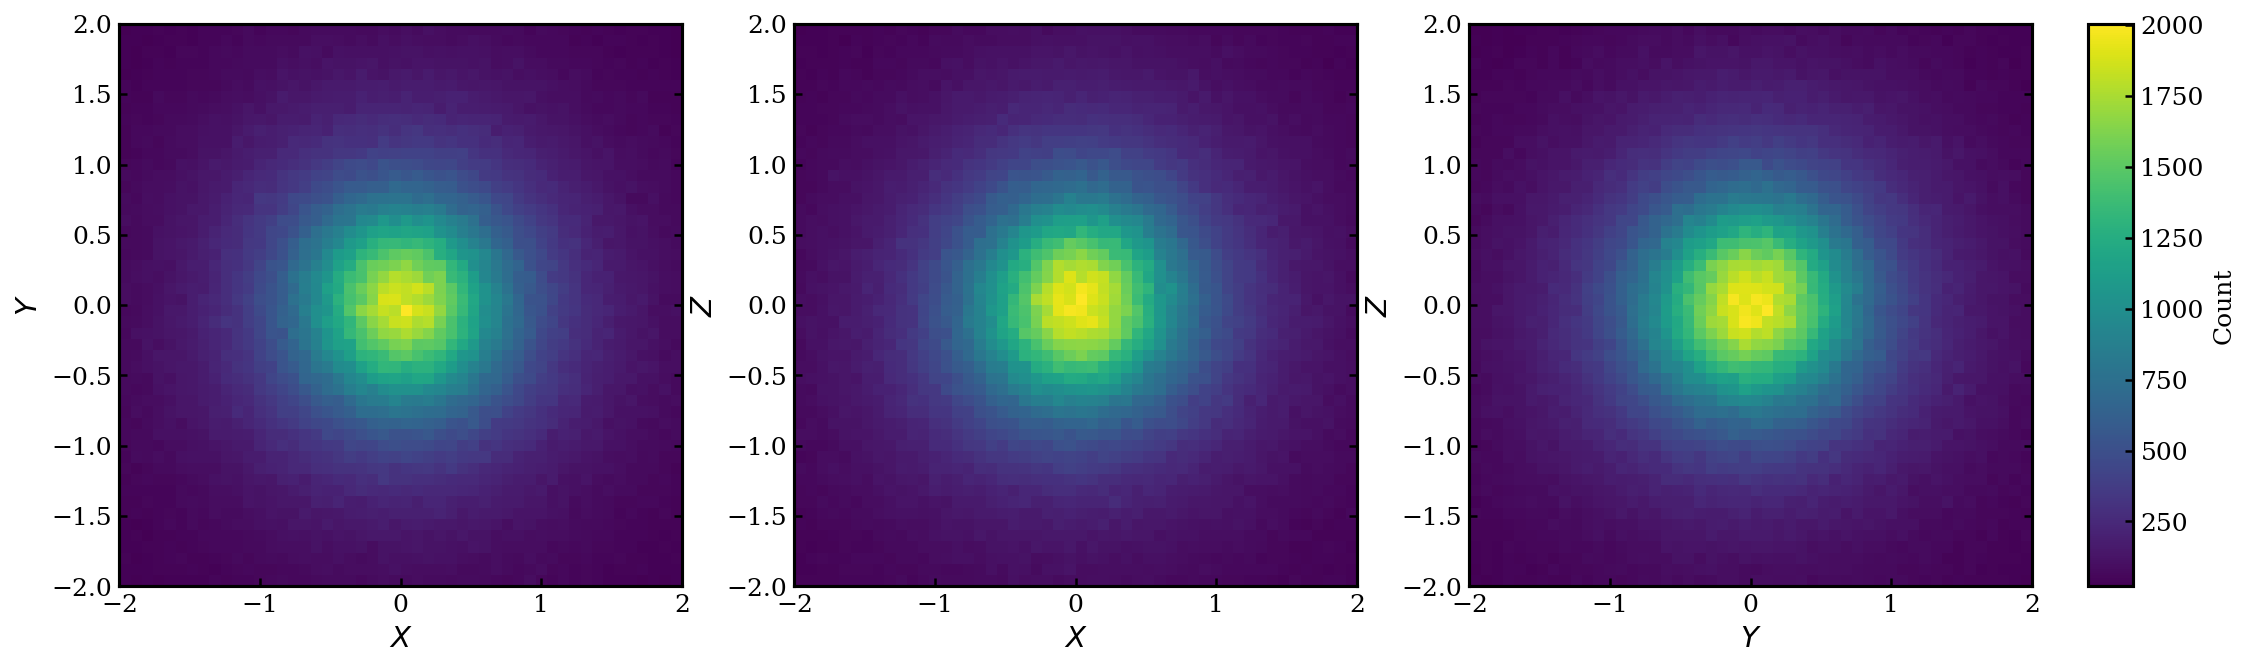

In [132]:
# position vector distribution
##############################3
fig = plt.figure(figsize=[15,5])
plt.gcf().set_facecolor('white')

# histogram: X vs Y
plt.subplot(1,3,1)
plt.hist2d(
    arr_pos_gen[:,0],
    arr_pos_gen[:,1],
    bins=[50,50],
    range=[[-2,2],[-2,2]],
    cmin=1,
);
plt.gca().set_aspect(1)
plt.gca().set_xlabel(r"$X$", fontsize=14)
plt.gca().set_ylabel(r"$Y$", fontsize=14)
plt.gca().set_position([0.05,0.17,0.3,0.75])

# histogram: X vs Z
plt.subplot(1,3,2)
plt.hist2d(
    arr_pos_gen[:,0],
    arr_pos_gen[:,2],
    bins=[50,50],
    range=[[-2,2],[-2,2]],
    cmin=1,
);
plt.gca().set_aspect(1)
plt.gca().set_xlabel(r"$X$", fontsize=14)
plt.gca().set_ylabel(r"$Z$", fontsize=14)
plt.gca().set_position([0.35,0.17,0.3,0.75])

# histogram: Y vs Z
plt.subplot(1,3,3)
_,_,_,im_yz = plt.hist2d(
    arr_pos_gen[:,1],
    arr_pos_gen[:,2],
    bins=[50,50],
    range=[[-2,2],[-2,2]],
    cmin=1,
);
plt.gca().set_aspect(1)
plt.gca().set_xlabel(r"$Y$", fontsize=14)
plt.gca().set_ylabel(r"$Z$", fontsize=14)
plt.gca().set_position([0.65,0.17,0.3,0.75])

# colorbar
cbar_ax = fig.add_axes([0.95, 0.17, 0.02, 0.75])
cbar = fig.colorbar(im_yz, cax=cbar_ax, label=r"Count")

plt.show()

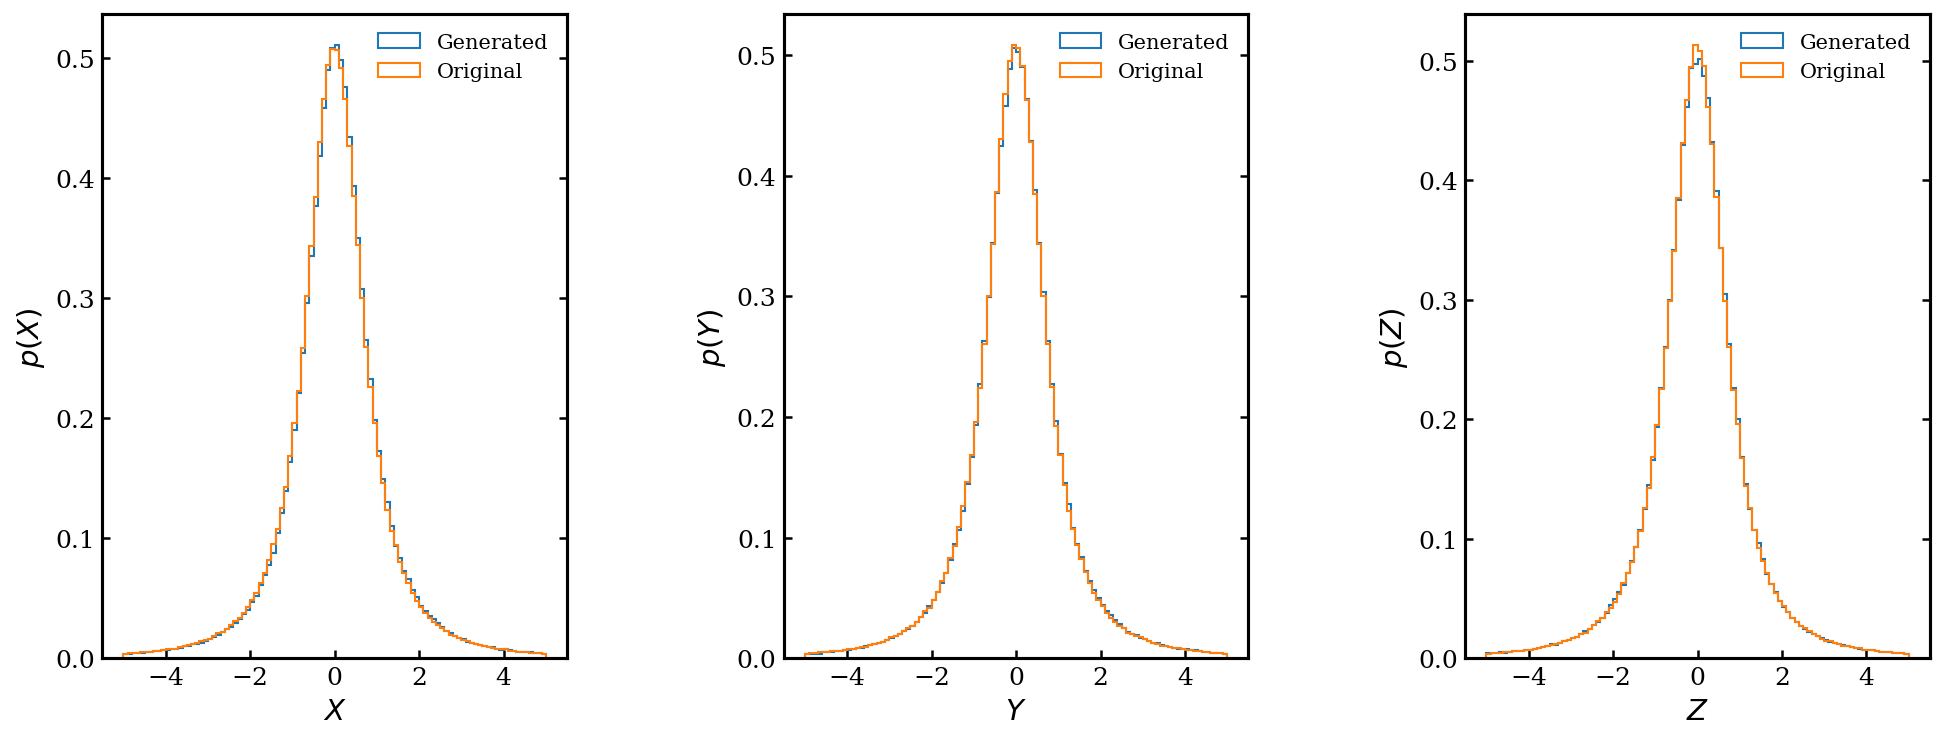

In [133]:
# Plot the x y and x distributions in 3 adjacent subplots
fig = plt.figure(figsize=[15,5])
plt.gcf().set_facecolor('white')

nbins = 100
RANGE = np.array([-1,1])*5

# histogram: X
plt.subplot(1,3,1)
xgenhist = plt.hist(
    (arr_pos_gen[:,0]),
    bins=nbins,
    range=RANGE,
    histtype='step',
    label='Generated',
    density=True,
)
xhist = plt.hist(
    (data[:,0]),
    bins=nbins,
    range=RANGE,
    histtype='step',
    label='Original',
    density=True,
)
plt.gca().set_xlabel(r"$X$", fontsize=14)
plt.gca().set_ylabel(r"$p(X)$", fontsize=14)
plt.gca().set_position([0.05,0.17,0.3,0.75])
plt.gca().legend()

# histogram: Y
plt.subplot(1,3,2)
ygenhist = plt.hist(
    (arr_pos_gen[:,1]),
    bins=nbins,
    range=RANGE,
    histtype='step',
    label='Generated',
    density=True,
)
yhist = plt.hist(
    (data[:,1]),
    bins=nbins,
    range=RANGE,
    histtype='step',
    label='Original',
    density=True,
)
plt.gca().set_xlabel(r"$Y$", fontsize=14)
plt.gca().set_ylabel(r"$p(Y)$", fontsize=14)
plt.gca().set_position([0.35,0.17,0.3,0.75])
plt.gca().legend()

# histogram: Z
plt.subplot(1,3,3)
zgenhist = plt.hist(
    arr_pos_gen[:,2],
    bins=nbins,
    range=RANGE,
    histtype='step',
    label='Generated',
    density=True,
)
zhist = plt.hist(
    data[:,2],
    bins=nbins,
    range=RANGE,
    histtype='step',
    label='Original',
    density=True,
)
plt.gca().set_xlabel(r"$Z$", fontsize=14)
plt.gca().set_ylabel(r"$p(Z)$", fontsize=14)
plt.gca().set_position([0.65,0.17,0.3,0.75])
plt.gca().legend()

plt.tight_layout()
plt.show()

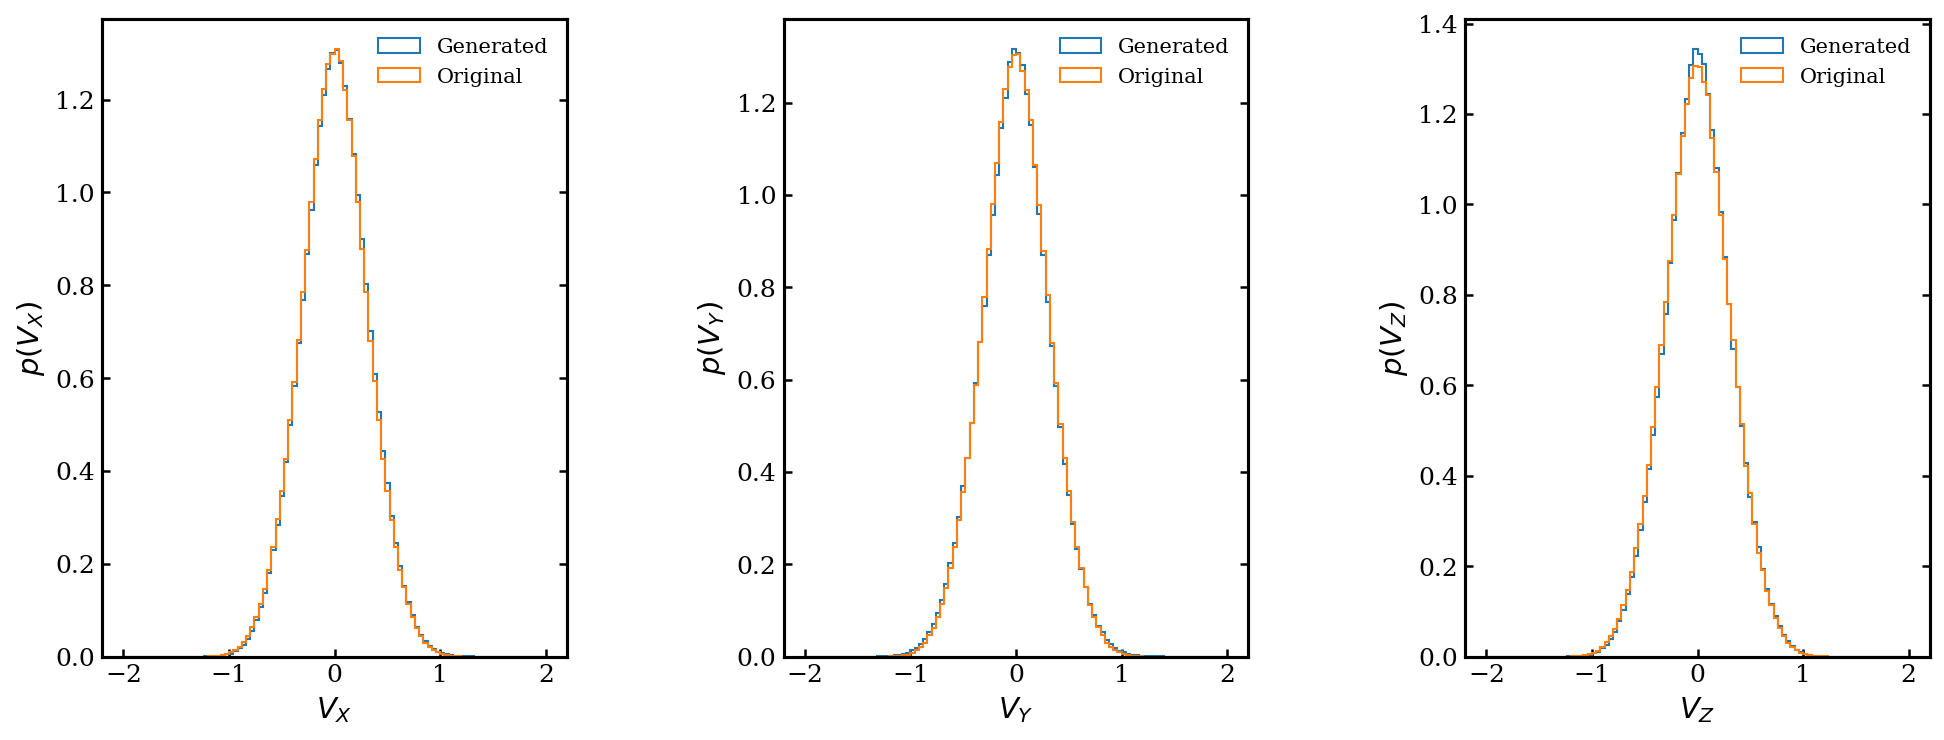

In [134]:
# Plot the x y and x distributions in 3 adjacent subplots
fig = plt.figure(figsize=[15,5])
plt.gcf().set_facecolor('white')

nbins = 100
RANGE = np.array([-1,1])*2

# histogram: X
plt.subplot(1,3,1)
xgenhist = plt.hist(
    (arr_pos_gen[:,3]),
    bins=nbins,
    range=RANGE,
    histtype='step',
    label='Generated',
    density=True,
)
xhist = plt.hist(
    (data[:,3]),
    bins=nbins,
    range=RANGE,
    histtype='step',
    label='Original',
    density=True,
)
plt.gca().set_xlabel(r"$V_X$", fontsize=14)
plt.gca().set_ylabel(r"$p(V_X)$", fontsize=14)
plt.gca().set_position([0.05,0.17,0.3,0.75])
plt.gca().legend()

# histogram: Y
plt.subplot(1,3,2)
ygenhist = plt.hist(
    (arr_pos_gen[:,4]),
    bins=nbins,
    range=RANGE,
    histtype='step',
    label='Generated',
    density=True,
)
yhist = plt.hist(
    (data[:,4]),
    bins=nbins,
    range=RANGE,
    histtype='step',
    label='Original',
    density=True,
)
plt.gca().set_xlabel(r"$V_Y$", fontsize=14)
plt.gca().set_ylabel(r"$p(V_Y)$", fontsize=14)
plt.gca().set_position([0.35,0.17,0.3,0.75])
plt.gca().legend()

# histogram: Z
plt.subplot(1,3,3)
zgenhist = plt.hist(
    arr_pos_gen[:,5],
    bins=nbins,
    range=RANGE,
    histtype='step',
    label='Generated',
    density=True,
)
zhist = plt.hist(
    data[:,5],
    bins=nbins,
    range=RANGE,
    histtype='step',
    label='Original',
    density=True,
)
plt.gca().set_xlabel(r"$V_Z$", fontsize=14)
plt.gca().set_ylabel(r"$p(V_Z)$", fontsize=14)
plt.gca().set_position([0.65,0.17,0.3,0.75])
plt.gca().legend()

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Generated Data: N = 250000')

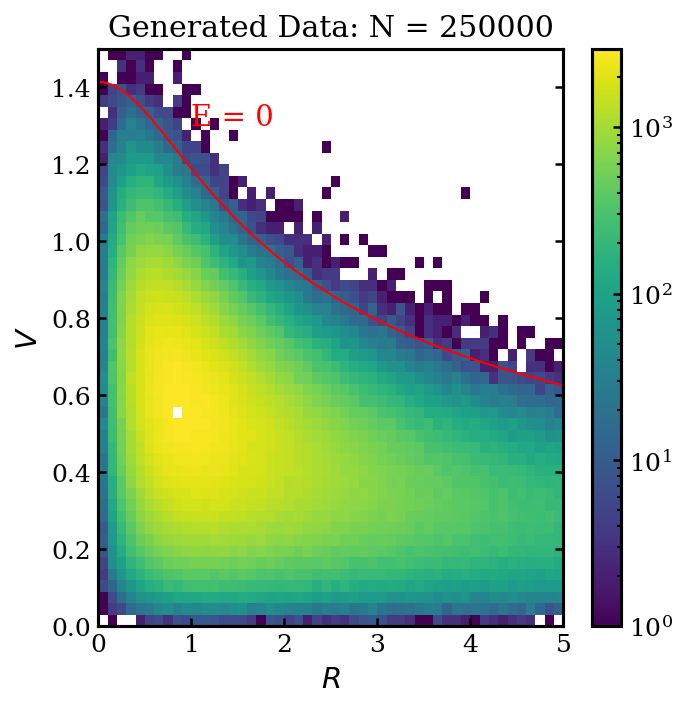

In [135]:
# Plot the distribution of v vs r

plt.figure(figsize=(5,5))
plt.hist2d(
    np.linalg.norm(arr_pos_gen[:,0:3],axis=1),
    np.linalg.norm(arr_pos_gen[:,3:],axis=1),
    bins=[50,50],
    range=[[0,5],[0,1.5]],
    cmin=0.,cmax=3.0e3,
    norm=LogNorm()
);
plt.colorbar()
# plot the analytic E=0 curve where E = 0.5 * v^2 - (1+r^2)^(-1/2)
r = np.linspace(0,5,100)
v = np.sqrt(2*(1/np.sqrt(1+r**2))) # E = 0
plt.plot(r,v,'r',linewidth=1)
# write the words "E = 0" on the plot just to make it clear
plt.text(1.0,1.3,'E = 0',fontsize=14,color='r')
#plt.gca().set_aspect(1)
plt.gca().set_xlabel(r"$R$", fontsize=14)
plt.gca().set_ylabel(r"$V$", fontsize=14)
plt.title(f'Generated Data: N = {int(n_train)}')


Text(0.5, 1.0, 'Ideal Data')

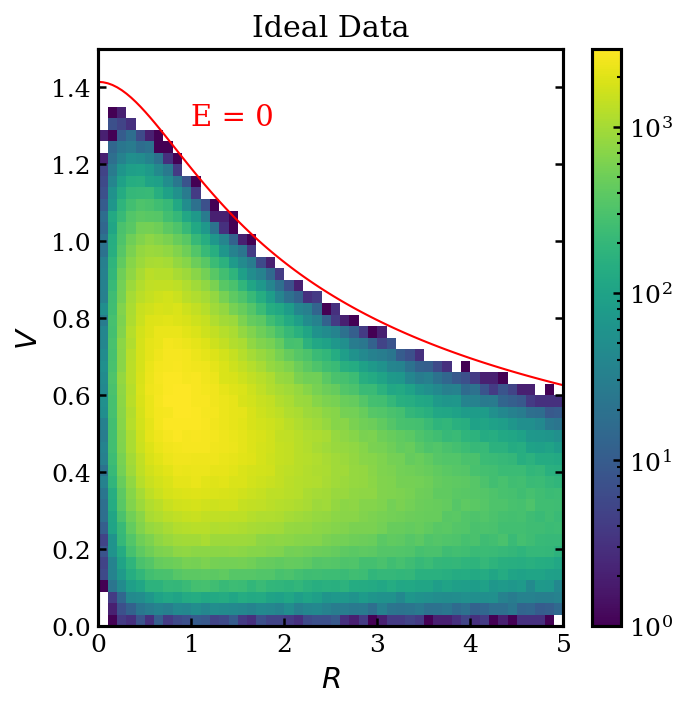

In [136]:
# Plot the distribution of v vs r but for the ORIGINAL DATASET

plt.figure(figsize=(5,5))
plt.hist2d(
    np.linalg.norm(data_original[:,0:3],axis=1),
    np.linalg.norm(data_original[:,3:],axis=1),
    bins=[50,50],
    range=[[0,5],[0,1.5]],
    cmin=0.,cmax = 3.0e3,
    norm=LogNorm()
);
plt.colorbar()
# plot the analytic E=0 curve where E = 0.5 * v^2 - (1+r^2)^(-1/2)
r = np.linspace(0,5,100)
v = np.sqrt(2*(1/np.sqrt(1+r**2))) # E = 0
plt.plot(r,v,'r',linewidth=1)
# write the words "E = 0" on the plot just to make it clear
plt.text(1.0,1.3,'E = 0',fontsize=14,color='r')
#plt.gca().set_aspect(1)
plt.gca().set_xlabel(r"$R$", fontsize=14)
plt.gca().set_ylabel(r"$V$", fontsize=14)
plt.title('Ideal Data')
